# **3D Head and Neck Tumor Segmentation (HNTS) using 3D Swin UNETR**

**Import necessary libraries**

In [1]:
import os
import zipfile
import shutil
import tempfile
import urllib.request

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import nibabel as nib

from monai.config import print_config
from monai.data import (
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    ThreadDataLoader,
)
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR
from torch.optim.lr_scheduler import ReduceLROnPlateau

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-26 13:15:19.708464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 13:15:19.723919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732623319.741837 3302431 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732623319.747325 3302431 

**Seed for Reproducibility**

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(0)

**Paramters**

In [3]:
# Paths
DATA_PATH = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
ZIP_FILE = os.path.join(DATA_PATH, 'HNTSMRG24_train.zip')
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'
TRAIN_DIR = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# Training Parameters
BATCH_SIZE_TRAIN = 3
NUM_WORKERS = 4
NUM_EPOCHS = 50
PRETRAIN_EPOCHS = 10
LEARNING_RATE = 1e-3
FINE_TUNNING_LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_CLASSES = 3
NUM_SAMPLES = 4
ACCUMULATION_STEPS = 4

# Learning Rate Scheduler Parameters
SCHEDULER_FACTOR = 0.5
SCHEDULER_PATIENCE = 5
SCHEDULER_MIN_LR = 1e-6

# Device Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# **Step 1: Load Data**

In [4]:
def extract_data(zip_file, extract_path):
    """
    Extracts preRT files from the dataset zip.
    """

    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
        zip_ref.extractall(path=extract_path, members=preRT_files)
    print(f"Data extracted to {extract_path}")

# Extract data
extract_data(ZIP_FILE, EXTRACTED_PATH)

Data extracted to /cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data


# **Step 2: Exploratory Data Analysis**

**Count number of patients**

In [5]:
# Path to the training data
train_dir = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(TRAIN_DIR)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


**Prepare EDA**

In [6]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders[:50]:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))

**EDA: Image Dimensions**

In [7]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data)

,Statistic,Width,Height,Depth
0,Minimum,512.00,480.00,57.00
1,Maximum,640.00,640.00,146.00
2,Mean (rounded),517.12,516.48,78.42


**EDA: Tumor Sizes**

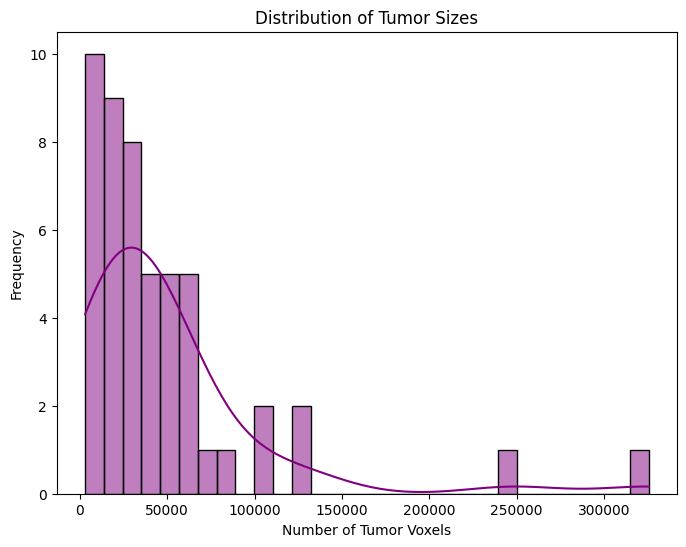

In [8]:
# Calculate tumor sizes
tumor_sizes = [counts.get(1, 0) + counts.get(2, 0) for counts in mask_voxel_counts]

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(tumor_sizes, bins=30, kde=True, color='purple')
plt.title('Distribution of Tumor Sizes')
plt.xlabel('Number of Tumor Voxels')
plt.ylabel('Frequency')
plt.show()

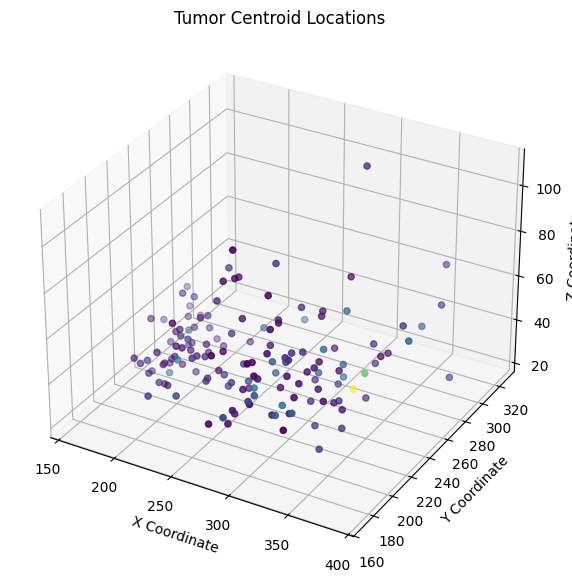

In [9]:
# Initialize lists
tumor_sizes = []
tumor_locations = []  # e.g., centroid coordinates or predefined regions

for patient_id in patient_folders:
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(int)

    # Calculate tumor size (number of voxels in tumor classes)
    tumor_voxels = mask_data > 0
    size = np.sum(tumor_voxels)
    tumor_sizes.append(size)

    # Calculate tumor centroid
    coords = np.column_stack(np.where(mask_data > 0))
    if coords.size > 0:
        centroid = coords.mean(axis=0)
        tumor_locations.append(centroid)
    else:
        tumor_locations.append([np.nan, np.nan, np.nan])

# Convert to DataFrame
eda_df = pd.DataFrame({
    'Patient_ID': patient_folders,
    'Tumor_Size': tumor_sizes,
    'Centroid_X': [loc[0] for loc in tumor_locations],
    'Centroid_Y': [loc[1] for loc in tumor_locations],
    'Centroid_Z': [loc[2] for loc in tumor_locations],
})

# 3D Scatter plot of tumor centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eda_df['Centroid_X'], eda_df['Centroid_Y'], eda_df['Centroid_Z'], c=eda_df['Tumor_Size'])
ax.set_title('Tumor Centroid Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.show()

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [10]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

# Define class labels
class_labels = {
    0: 'Background',
    1: 'GTVp',
    2: 'GTVn'
}

# Create a DataFrame for class distribution
class_df = pd.DataFrame({
    'Class': [class_labels.get(cls, f'Class {cls}') for cls in class_percentages.keys()],
    'Percentage (%)': [round(pct, 4) for pct in class_percentages.values()]
})

# Display the DataFrame
class_df

,Class,Percentage (%)
0,Background,99.7664
1,GTVp,0.1041
2,GTVn,0.1296


**EDA: Plot samples to check quality and type of data**

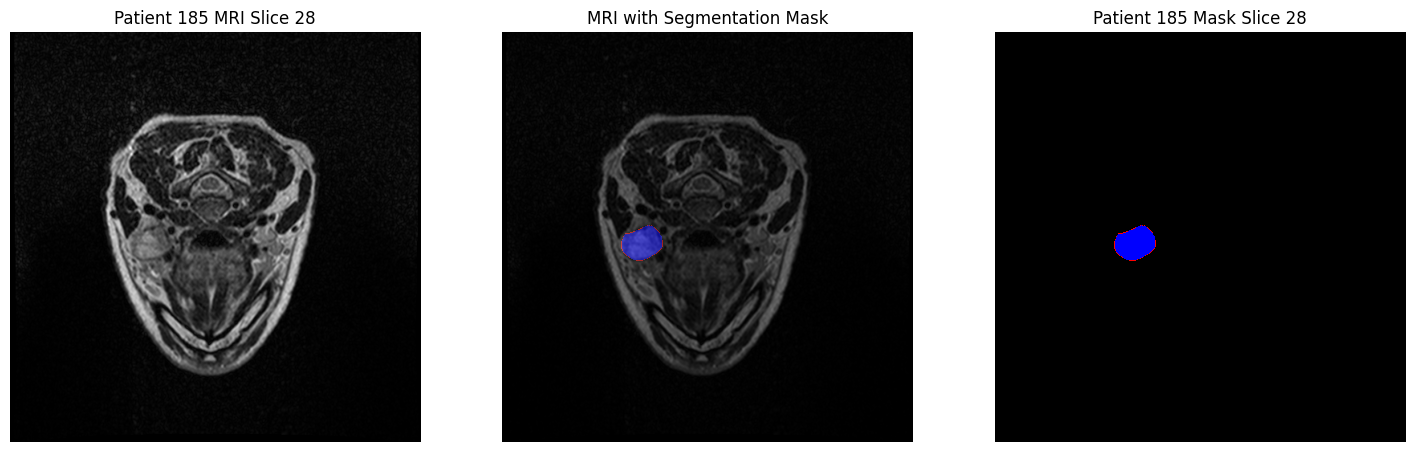

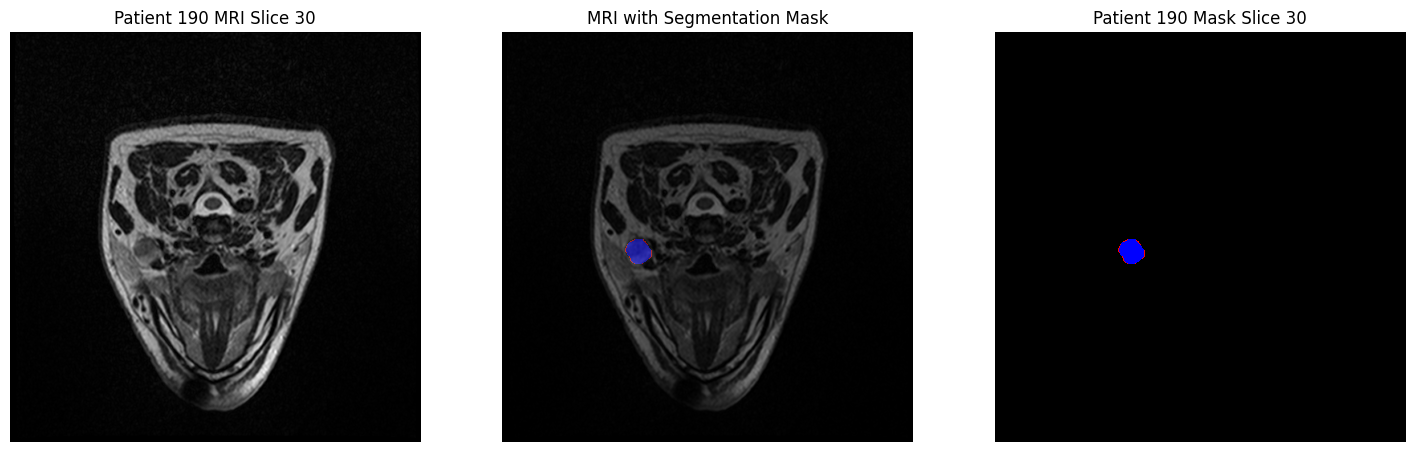

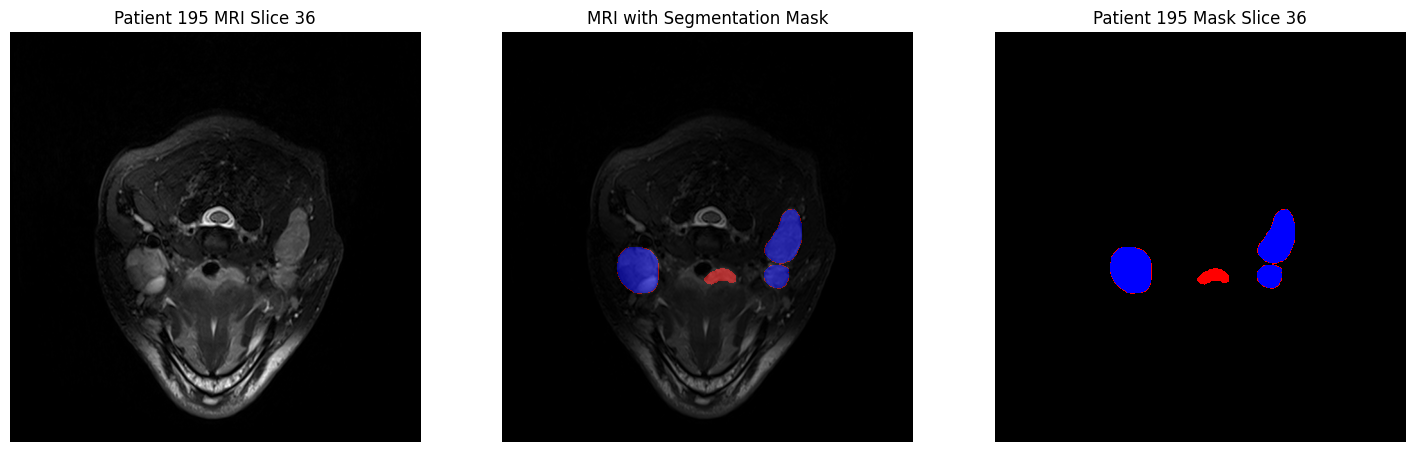

In [11]:
def plot_sample(patient_id, slice_index=None):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select the middle slice
    slice_index = mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. MRI Image
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].set_title(f'Patient {patient_id} MRI Slice {slice_index}')
    axes[0].axis('off')
    
    # 2. MRI with Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')
    
    # 3. Mask Only
    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Mask Slice {slice_index}')
    axes[2].axis('off')

    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

**Create data dictionary**

In [12]:
def create_data_dicts(train_dir):
    """
    Creates data dictionaries for MONAI.
    """
    data_dicts = [
        {
            "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
            "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
        }
        for pid in patient_folders
    ]
    return data_dicts

# Create data dictionaries
data_dicts = create_data_dicts(TRAIN_DIR)

**Split the dataset into training and validation (80/20)**

In [13]:
# Split data into training and validation sets
train_files = data_dicts[:120]
val_files = data_dicts[120:]
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 120, Validation samples: 30


**Transform images**

In [14]:
# Transform the images for training
train_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
            ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image"),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),

        # Randomly crop based on labels
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=NUM_SAMPLES,
            image_key="image",
            image_threshold=0,
        ),
        
        # Apply random flips
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),

        # Apply random rotations
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),

        # Random intensity shift
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
    ]
)

# Transform the images for validation
val_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image"),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


**Create datasets**

In [15]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


**Create DataLoaders**

In [16]:
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=3, shuffle=True)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)


Train Batch 1:


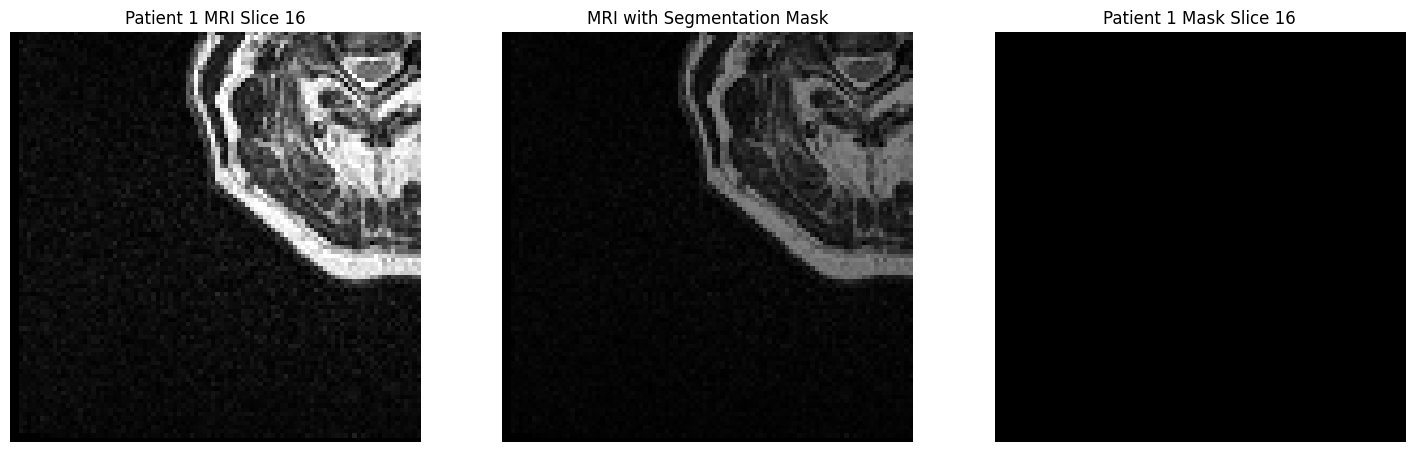

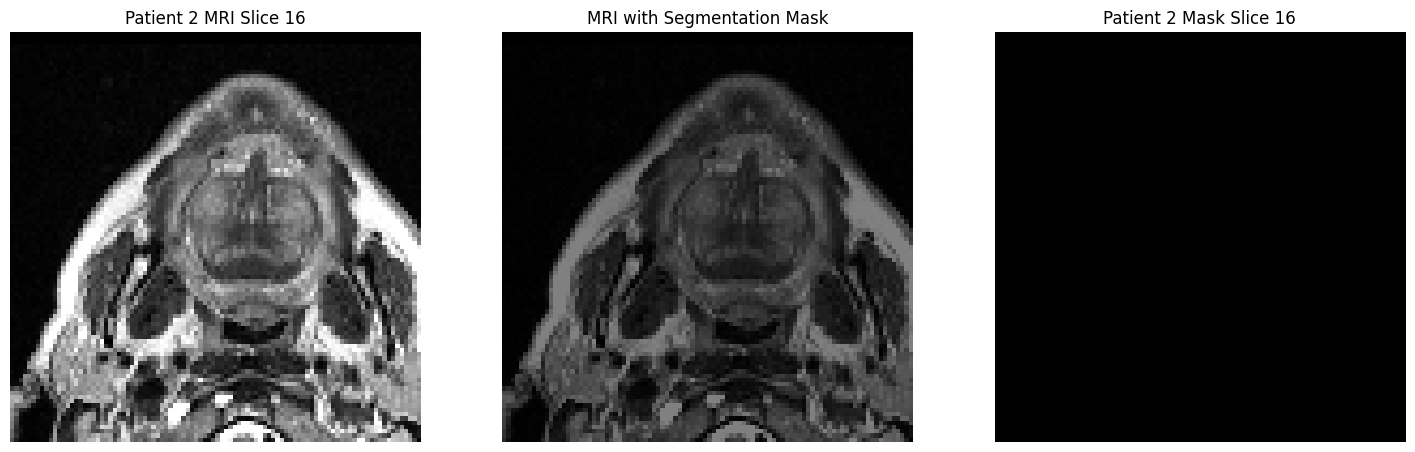


Train Batch 2:


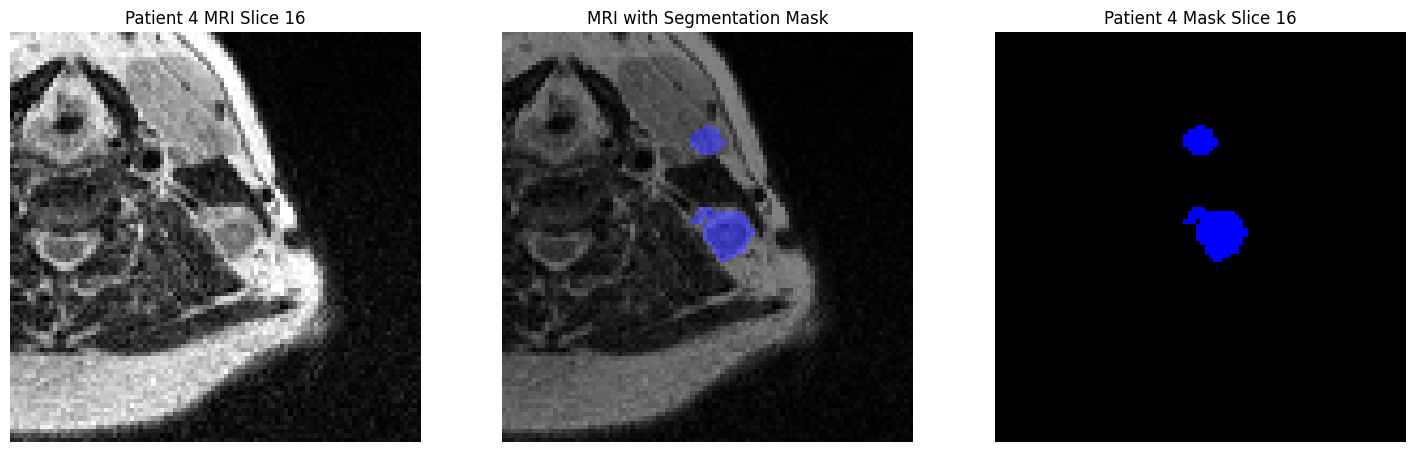

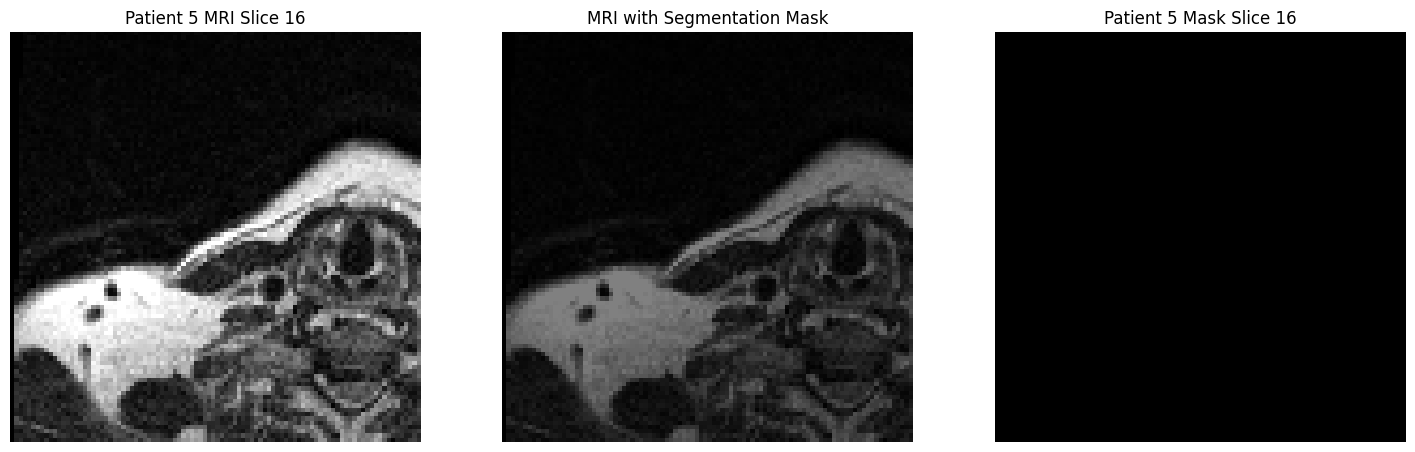


Validation Batch 1:


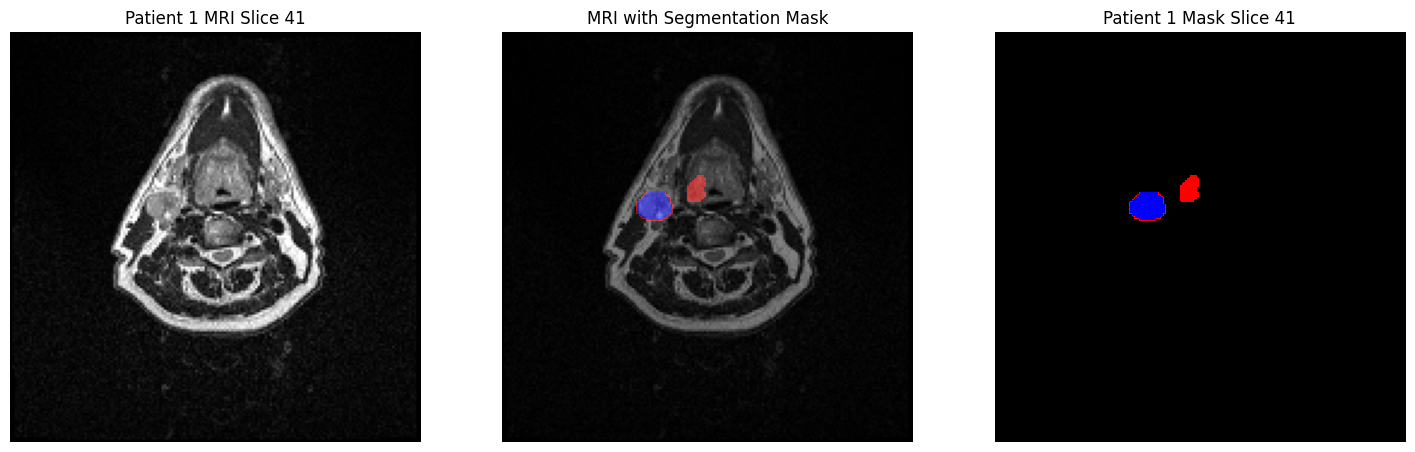

In [17]:
def plot_dataloader_sample(image_tensor, label_tensor, patient_id=None, slice_index=None):
    """
    Plots MRI image, MRI with segmentation mask overlay, and mask only from tensors.
    """
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)

    if label_np.ndim == 4 and label_np.shape[0] == 1:
        label_np = np.squeeze(label_np, axis=0)

    if slice_index is None:
        slice_index = image_np.shape[2] // 2

    mri_slice = image_np[:, :, slice_index].T
    mask_slice = label_np[:, :, slice_index].T

    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    title1 = f'Patient {patient_id} MRI Slice {slice_index}' if patient_id else f'MRI Slice {slice_index}'
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    title3 = f'Patient {patient_id} Mask Slice {slice_index}' if patient_id else f'Mask Slice {slice_index}'
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.show()

def visualize_dataloader_samples(dataloader, num_batches=1, samples_per_batch=2, mode='Train'):
    """
    Visualizes samples from the dataloader.
    """
    for batch_idx, batch_data in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images = batch_data["image"]
        labels = batch_data["label"]

        batch_size = images.shape[0]
        print(f"\n{mode} Batch {batch_idx + 1}:")
        for i in range(min(samples_per_batch, batch_size)):
            image = images[i]
            label = labels[i]
            patient_id = f"{batch_idx * dataloader.batch_size + i + 1}"
            plot_dataloader_sample(image, label, patient_id=patient_id)

# Example visualization
visualize_dataloader_samples(train_loader, num_batches=2, samples_per_batch=2, mode='Train')
visualize_dataloader_samples(val_loader, num_batches=1, samples_per_batch=1, mode='Validation')

**Prepare for usage of GPU**

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 5: Build Model**

**Initialize SwinUNETR Model**

In [19]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,
).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


**Download pre-trained weights**

In [20]:
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt
# TODO Uncomment

**Load weights**

In [21]:
weight = torch.load("./model_swinvit.pt")
model.load_from(weights=weight)

/tmp/ipykernel_3302431/2594813349.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load("./model_swinvit.pt")


**Freeze all without the 10 last layers**

In [22]:
# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Retrieve the 10 last layers
all_layers = list(model.named_parameters())
last_10_layers = all_layers[-10:]

# Set requires_grad=True for the last 10 layers
for name, param in last_10_layers:
    param.requires_grad = True

# Print parameter states for verification
print("Parameter states after modification:")
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Parameter states after modification:
swinViT.patch_embed.proj.weight: requires_grad=False
swinViT.patch_embed.proj.bias: requires_grad=False
swinViT.layers1.0.blocks.0.norm1.weight: requires_grad=False
swinViT.layers1.0.blocks.0.norm1.bias: requires_grad=False
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table: requires_grad=False
swinViT.layers1.0.blocks.0.attn.qkv.weight: requires_grad=False
swinViT.layers1.0.blocks.0.attn.qkv.bias: requires_grad=False
swinViT.layers1.0.blocks.0.attn.proj.weight: requires_grad=False
swinViT.layers1.0.blocks.0.attn.proj.bias: requires_grad=False
swinViT.layers1.0.blocks.0.norm2.weight: requires_grad=False
swinViT.layers1.0.blocks.0.norm2.bias: requires_grad=False
swinViT.layers1.0.blocks.0.mlp.linear1.weight: requires_grad=False
swinViT.layers1.0.blocks.0.mlp.linear1.bias: requires_grad=False
swinViT.layers1.0.blocks.0.mlp.linear2.weight: requires_grad=False
swinViT.layers1.0.blocks.0.mlp.linear2.bias: requires_grad=False
swinViT.layers1.0.b

# **Step 6: Train and Validate Model**

**Define Loss, Optimizer, and Metrics**

In [23]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

post_label = AsDiscrete(to_onehot=NUM_CLASSES)
post_pred = AsDiscrete(argmax=True, to_onehot=NUM_CLASSES)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

/tmp/ipykernel_3302431/567529329.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


**Training Loop**

In [24]:
# Post-processing for metrics
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

# Initialize Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Initialize lists to store loss values
train_losses = []
val_losses = []
dice_scores = []

best_dice = 0.0  # Initialize best Dice score
best_epoch = 0  # To track which epoch had the best Dice score

# Initialize the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Because higher Dice score is better
    factor=SCHEDULER_FACTOR,
    patience=SCHEDULER_PATIENCE,
    verbose=True,
    min_lr=SCHEDULER_MIN_LR
)

# Training Loop
for epoch in range(NUM_EPOCHS):

    # ----------- Training Phase -----------
    model.train()
    epoch_loss = 0.0
    step = 0
    progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_data in progress_bar:
        step += 1

        # Unfreeze all parameters after pretraining
        if epoch == PRETRAIN_EPOCHS:
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=FINE_TUNNING_LEARNING_RATE, weight_decay=WEIGHT_DECAY)

            # Re-initialize the scheduler
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=SCHEDULER_FACTOR,
                patience=SCHEDULER_PATIENCE,
                verbose=True,
                min_lr=SCHEDULER_MIN_LR
            )

        # Retrieve training samples
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.amp.autocast(str(device)):

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels) / ACCUMULATION_STEPS

        # Backward pass
        scaler.scale(loss).backward()

        # Calculate epoch loss
        epoch_loss += loss.item() * ACCUMULATION_STEPS

        if step % ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": loss.item()*ACCUMULATION_STEPS})

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)


    # ----------- Validation Phase -----------
    model.eval()
    val_loss = 0.0
    dice_metric.reset()
    progress_bar = tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{NUM_EPOCHS}")

    with torch.no_grad():
        for val_batch in progress_bar:

            # Retrieve validation samples
            val_inputs = val_batch["image"].cuda()
            val_labels = val_batch["label"].cuda()

            with torch.amp.autocast(str(device)):
                # Forward pass with sliding window inference for large images
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

                # Compute validation loss
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()

            # Post-processing for Dice metric
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # Update progress bar
            progress_bar.set_postfix({"Loss": loss.item()})
    
    # Calculate average validation loss and Dice score for the epoch
    avg_val_loss = val_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()

    # Save losses
    val_losses.append(avg_val_loss)
    dice_scores.append(dice_score)

    # Step the scheduler based on validation Dice score
    scheduler.step(dice_score)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_epoch_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Dice Score: {dice_score:.4f}")


    # ----------- Model Checkpointing -----------
    if dice_score > best_dice:
        best_dice = dice_score
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"New best Dice score! Model saved at epoch {best_epoch} with Dice: {best_dice:.4f}")
    else:
        print(f"No improvement in Dice score this epoch.")


/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


Epoch [1/50], Train Loss: 1.5633, Val Loss: 1.4072, Dice Score: 0.3741
New best Dice score! Model saved at epoch 1 with Dice: 0.3741


Epoch 2/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch [2/50], Train Loss: 1.1480, Val Loss: 1.1529, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 3/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [3/50], Train Loss: 0.9700, Val Loss: 0.9506, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 4/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch [4/50], Train Loss: 0.8662, Val Loss: 0.8588, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 5/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [5/50], Train Loss: 0.8077, Val Loss: 0.8079, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 6/50: 100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


Epoch [6/50], Train Loss: 0.7741, Val Loss: 0.7765, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 7/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch [7/50], Train Loss: 0.7537, Val Loss: 0.7648, Dice Score: 0.3728
No improvement in Dice score this epoch.


Epoch 8/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch [8/50], Train Loss: 0.7434, Val Loss: 0.7482, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 9/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch [9/50], Train Loss: 0.7343, Val Loss: 0.7464, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 10/50: 100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


Epoch [10/50], Train Loss: 0.7268, Val Loss: 0.7444, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 11/50:   0%|          | 0/40 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
Epoch 11/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [11/50], Train Loss: 0.7229, Val Loss: 0.7376, Dice Score: 0.3719
No improvement in Dice score this epoch.


Epoch 12/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [12/50], Train Loss: 0.7133, Val Loss: 0.7292, Dice Score: 0.3739
No improvement in Dice score this epoch.


Epoch 13/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [13/50], Train Loss: 0.7029, Val Loss: 0.7250, Dice Score: 0.4083
New best Dice score! Model saved at epoch 13 with Dice: 0.4083


Epoch 14/50: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Epoch [14/50], Train Loss: 0.6945, Val Loss: 0.7199, Dice Score: 0.4177
New best Dice score! Model saved at epoch 14 with Dice: 0.4177


Epoch 15/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [15/50], Train Loss: 0.6919, Val Loss: 0.7119, Dice Score: 0.4006
No improvement in Dice score this epoch.


Epoch 16/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [16/50], Train Loss: 0.6869, Val Loss: 0.7064, Dice Score: 0.4082
No improvement in Dice score this epoch.


Epoch 17/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [17/50], Train Loss: 0.6805, Val Loss: 0.7056, Dice Score: 0.4317
New best Dice score! Model saved at epoch 17 with Dice: 0.4317


Epoch 18/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [18/50], Train Loss: 0.6779, Val Loss: 0.7027, Dice Score: 0.4224
No improvement in Dice score this epoch.


Epoch 19/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [19/50], Train Loss: 0.6739, Val Loss: 0.7034, Dice Score: 0.4423
New best Dice score! Model saved at epoch 19 with Dice: 0.4423


Epoch 20/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [20/50], Train Loss: 0.6622, Val Loss: 0.7034, Dice Score: 0.4207
No improvement in Dice score this epoch.


Epoch 21/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [21/50], Train Loss: 0.6615, Val Loss: 0.6883, Dice Score: 0.4510
New best Dice score! Model saved at epoch 21 with Dice: 0.4510


Epoch 22/50: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Epoch [22/50], Train Loss: 0.6579, Val Loss: 0.6832, Dice Score: 0.4385
No improvement in Dice score this epoch.


Epoch 23/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [23/50], Train Loss: 0.6459, Val Loss: 0.6790, Dice Score: 0.4736
New best Dice score! Model saved at epoch 23 with Dice: 0.4736


Epoch 24/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [24/50], Train Loss: 0.6424, Val Loss: 0.6866, Dice Score: 0.4433
No improvement in Dice score this epoch.


Epoch 25/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [25/50], Train Loss: 0.6369, Val Loss: 0.6743, Dice Score: 0.4614
No improvement in Dice score this epoch.


Epoch 26/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [26/50], Train Loss: 0.6324, Val Loss: 0.6788, Dice Score: 0.4579
No improvement in Dice score this epoch.


Epoch 27/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [27/50], Train Loss: 0.6247, Val Loss: 0.6659, Dice Score: 0.4899
New best Dice score! Model saved at epoch 27 with Dice: 0.4899


Epoch 28/50: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Epoch [28/50], Train Loss: 0.6189, Val Loss: 0.6712, Dice Score: 0.4654
No improvement in Dice score this epoch.


Epoch 29/50: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Epoch [29/50], Train Loss: 0.6264, Val Loss: 0.6531, Dice Score: 0.5172
New best Dice score! Model saved at epoch 29 with Dice: 0.5172


Epoch 30/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [30/50], Train Loss: 0.6197, Val Loss: 0.6608, Dice Score: 0.4794
No improvement in Dice score this epoch.


Epoch 31/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [31/50], Train Loss: 0.6050, Val Loss: 0.6670, Dice Score: 0.4770
No improvement in Dice score this epoch.


Epoch 32/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [32/50], Train Loss: 0.6007, Val Loss: 0.6342, Dice Score: 0.5431
New best Dice score! Model saved at epoch 32 with Dice: 0.5431


Epoch 33/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [33/50], Train Loss: 0.6230, Val Loss: 0.6668, Dice Score: 0.4419
No improvement in Dice score this epoch.


Epoch 34/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [34/50], Train Loss: 0.6146, Val Loss: 0.6485, Dice Score: 0.4929
No improvement in Dice score this epoch.


Epoch 35/50: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Epoch [35/50], Train Loss: 0.6010, Val Loss: 0.6500, Dice Score: 0.4824
No improvement in Dice score this epoch.


Epoch 36/50: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Epoch [36/50], Train Loss: 0.5901, Val Loss: 0.6282, Dice Score: 0.5322
No improvement in Dice score this epoch.


Epoch 37/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [37/50], Train Loss: 0.5893, Val Loss: 0.6323, Dice Score: 0.5299
No improvement in Dice score this epoch.


Epoch 38/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [38/50], Train Loss: 0.5873, Val Loss: 0.6359, Dice Score: 0.4987
No improvement in Dice score this epoch.


Epoch 39/50: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


Epoch [39/50], Train Loss: 0.5771, Val Loss: 0.6273, Dice Score: 0.5317
No improvement in Dice score this epoch.


Epoch 40/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [40/50], Train Loss: 0.5791, Val Loss: 0.6287, Dice Score: 0.5163
No improvement in Dice score this epoch.


Epoch 41/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [41/50], Train Loss: 0.5834, Val Loss: 0.6274, Dice Score: 0.5219
No improvement in Dice score this epoch.


Epoch 42/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [42/50], Train Loss: 0.5638, Val Loss: 0.6242, Dice Score: 0.5490
New best Dice score! Model saved at epoch 42 with Dice: 0.5490


Epoch 43/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [43/50], Train Loss: 0.5720, Val Loss: 0.6158, Dice Score: 0.5391
No improvement in Dice score this epoch.


Epoch 44/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [44/50], Train Loss: 0.5588, Val Loss: 0.6138, Dice Score: 0.5597
New best Dice score! Model saved at epoch 44 with Dice: 0.5597


Epoch 45/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [45/50], Train Loss: 0.5557, Val Loss: 0.6091, Dice Score: 0.5562
No improvement in Dice score this epoch.


Epoch 46/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [46/50], Train Loss: 0.5565, Val Loss: 0.6147, Dice Score: 0.5418
No improvement in Dice score this epoch.


Epoch 47/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [47/50], Train Loss: 0.5657, Val Loss: 0.6191, Dice Score: 0.5265
No improvement in Dice score this epoch.


Epoch 48/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [48/50], Train Loss: 0.5669, Val Loss: 0.6068, Dice Score: 0.5509
No improvement in Dice score this epoch.


Epoch 49/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Epoch [49/50], Train Loss: 0.5474, Val Loss: 0.6053, Dice Score: 0.5658
New best Dice score! Model saved at epoch 49 with Dice: 0.5658


Epoch 50/50: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

Epoch [50/50], Train Loss: 0.5608, Val Loss: 0.6133, Dice Score: 0.5358
No improvement in Dice score this epoch.


**Plot Training and Validation Loss**

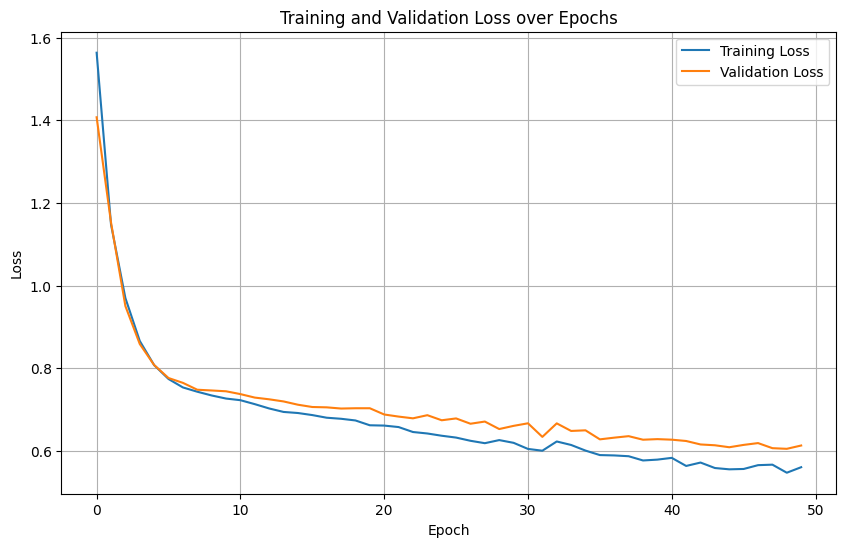

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Dice Score over Epochs**

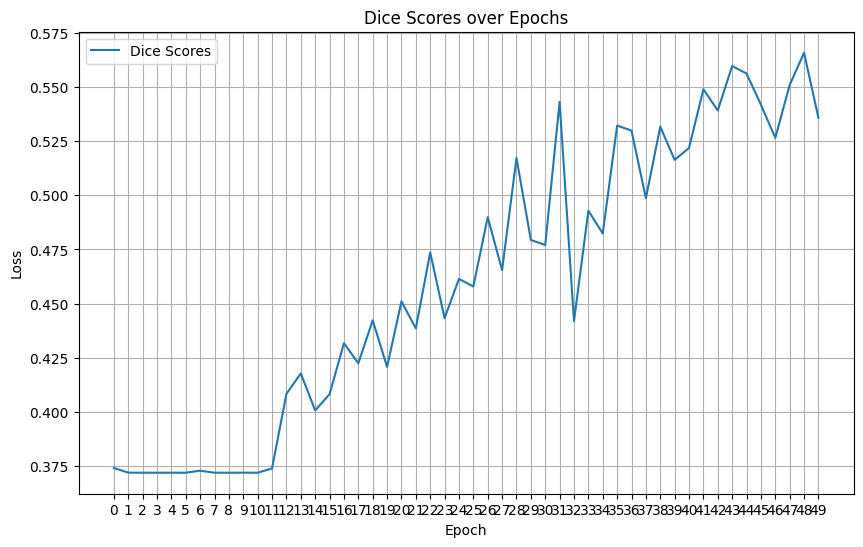

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(dice_scores)), dice_scores, label='Dice Scores')
plt.title('Dice Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, len(dice_scores)))
plt.legend()
plt.grid(True)
plt.show()

**Plot Predicted Samples**

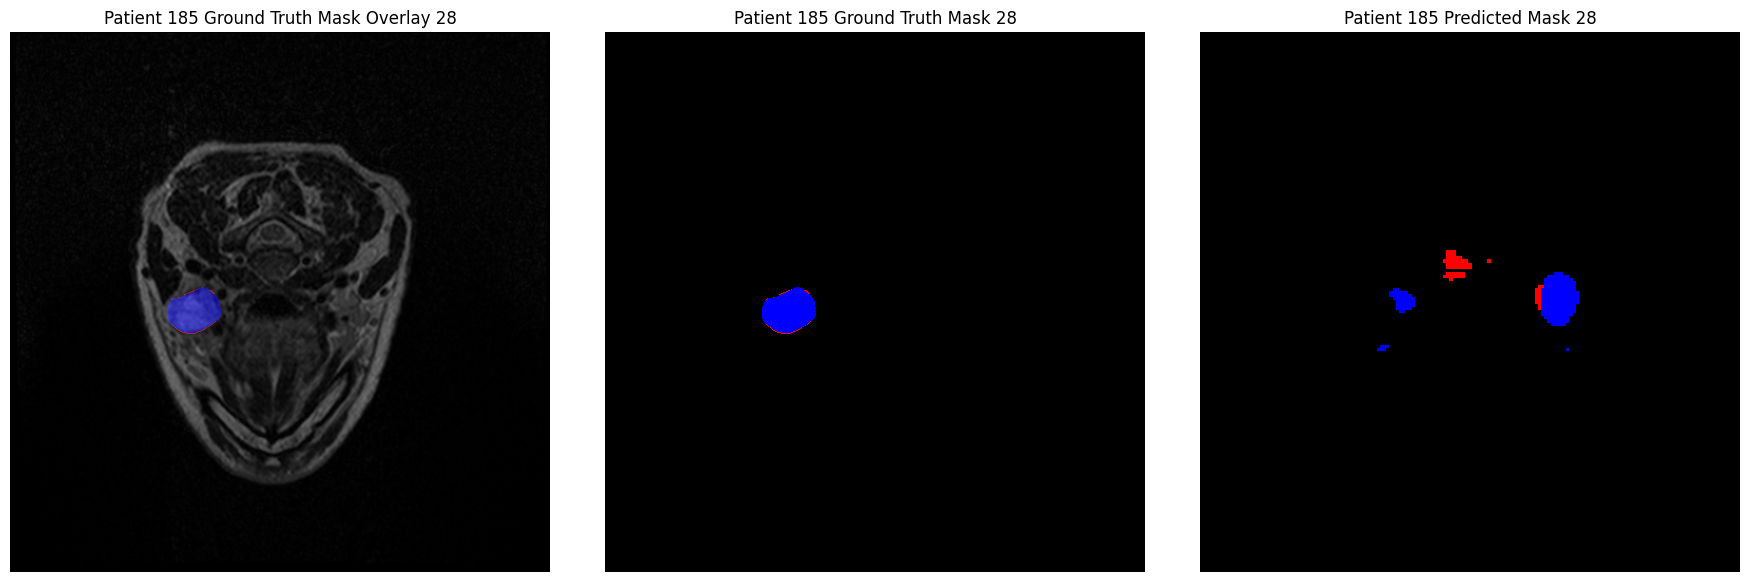

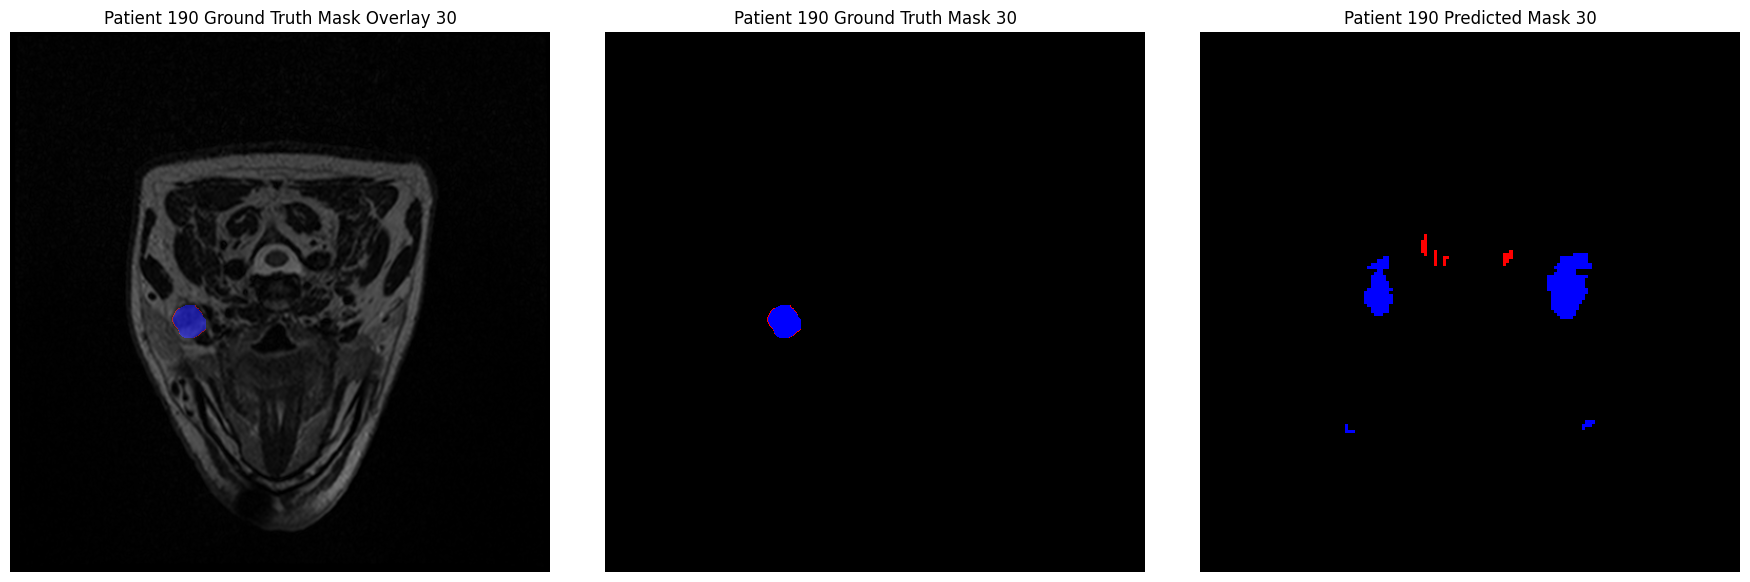

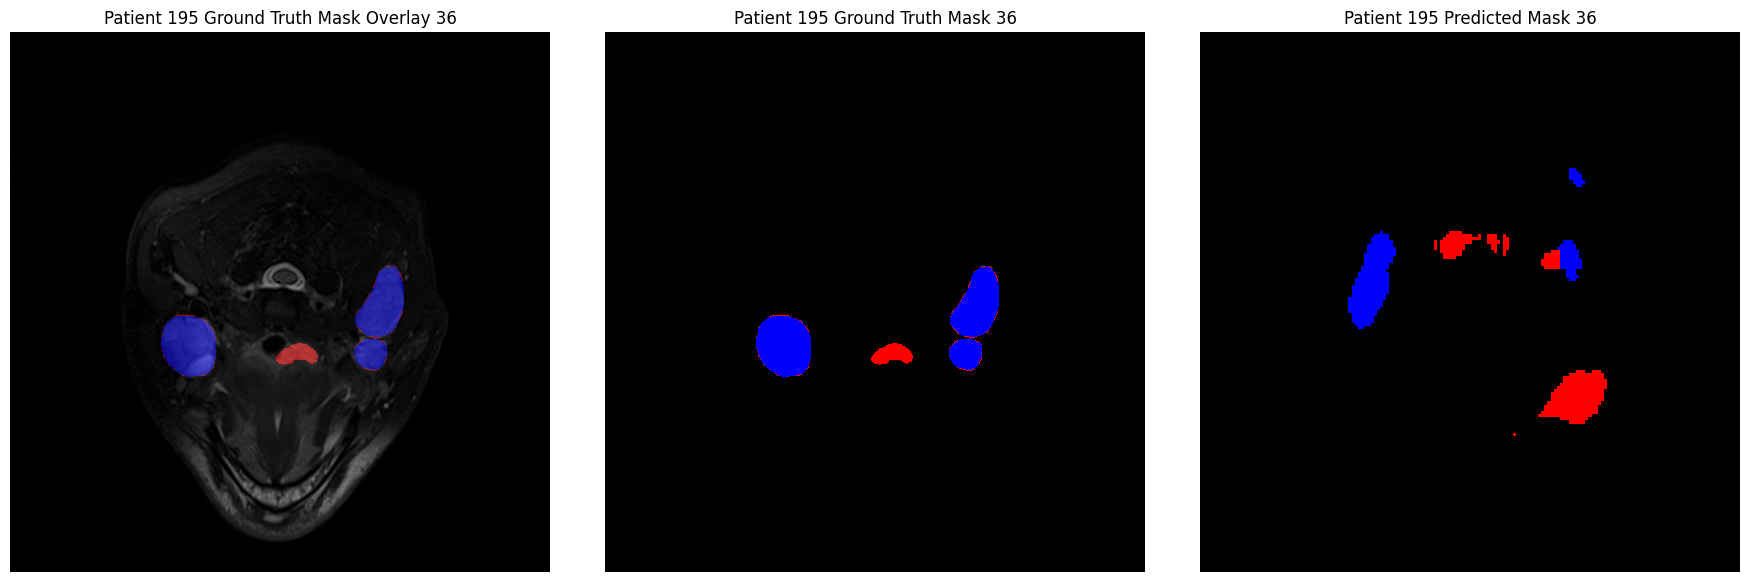

In [27]:
def plot_prediction(train_dir, val_transforms, model, patient_id, slice_index=None, device='cpu'):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select middle slice if not specified
    slice_index = slice_index or mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T

    # Preprocess and predict
    model.eval()
    with torch.no_grad():
        processed = val_transforms({"image": mri_path, "label": mask_path})
        with torch.amp.autocast(str(device)):
            input_tensor = processed["image"].unsqueeze(0).to(device)
            output = sliding_window_inference(input_tensor, (96, 96, 96), 4, model)
            probabilities = torch.softmax(output, dim=1)
            predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the predicted slice and transpose
    predicted_slice = predicted[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Ground Truth Mask Overlay
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[0].set_title(f'Patient {patient_id} Ground Truth Mask Overlay {slice_index}')
    axes[0].axis('off')

    # 2. Ground Truth Mask
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[1].set_title(f'Patient {patient_id} Ground Truth Mask {slice_index}')
    axes[1].axis('off')
    
    # 3. Predicted Mask
    axes[2].imshow(predicted_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Predicted Mask {slice_index}')
    axes[2].axis('off')
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_prediction(TRAIN_DIR, val_transforms, model, patient_id=pid, device=device)